In [237]:
%matplotlib notebook
import pandas as pd
import glob
from google.cloud import bigquery
from bq_helper import BigQueryHelper
import os
import numpy as np

import sklearn
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib

from sklearn.metrics import roc_curve, auc

import statsmodels.api as sm
import statsmodels.discrete.discrete_model as statsdisc
import matplotlib.pyplot as plt

from common_funcs import *

import itertools

from imblearn.over_sampling import SMOTE

from scipy import interp

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [220]:
main_table = remove_unnamed_cols(pd.read_csv('main_table.csv'))
main_table.columns

Index(['project_id', 'name', 'readme_len', 'readme_size', 'readme_headers',
       'pipeline_status', 'url_count', 'img_count', 'code_files',
       'code_files_examined', 'code_loc', 'code_lloc', 'code_sloc',
       'code_comments', 'code_multi', 'code_blank', 'code_single_comments',
       'code_functions_complexity', 'code_classes_complexity',
       'code_total_complexity', 'code_halstead_h1', 'code_halstead_h2',
       'code_halstead_N1', 'code_halstead_N2', 'code_halstead_vocabulary',
       'code_halstead_length', 'code_halstead_calculated_length',
       'code_halstead_volume', 'code_halstead_difficulty',
       'code_halstead_effort', 'code_halstead_time', 'code_halstead_bugs',
       'code_pylint_score', 'url', 'main_commits', 'sec_commits17',
       'sec_commits18', 'cloned', 'sec_commits18_times4', 'sc17_cat',
       'sc18_cat', 'sc_diff', 'sc_diff_sign', 'code_files_avg',
       'code_files_examined_avg', 'code_loc_avg', 'code_lloc_avg',
       'code_sloc_avg', 'code_comme

In [221]:
code_columns = [i for i in list(main_table.columns) if 'code_' in i and '_avg' not in i]
len(code_columns)

25

In [222]:
main_table = main_table.sort_values(by='sec_commits17')
main_table.head()

project_id           name  readme_len  readme_size  readme_headers  \
2289    53624886       FlashMap           0            0               0   
933     22694091  iot-utilities        1270           19               0   
1736    42941786      CoilSnake        3509           81               3   
4119    36684455  doc-icommerce        1829           61               5   
4268    33378673           docs        1188           25               2   

      pipeline_status  url_count  img_count  code_files  code_files_examined  \
2289                0          0          0           5                    2   
933                 0          0          0           9                    7   
1736                0          4          0          92                   10   
4119                0          4          0           1                    1   
4268                0          4          0           1                    1   

       ...     code_halstead_difficulty_avg  code_halstead_effort_avg  \
2289   ...                         0.049353                 16.337027   
933    ...                         0.014085                 60.401914   
1736   ...                         0.021313                 60.672586   
4119   ...                         0.000000                  0.000000   
4268   ...                         0.000000                  0.000000   

      code_halstead_time_avg  code_halstead_bugs_avg  code_pylint_score_avg  \
2289                0.907613                0.001596                    0.0   
933                 3.355662                0.001745                    0.0   
1736                3.370699                0.001842                    0.0   
4119                0.000000                0.000000                    0.0   
4268                0.000000                0.000000                    0.0   

       l_sc17      l_mc  diff_cat    lsc17    lsc18  
2289  0.00995  0.009950         0  0.00995 -4.60517  
933   0.00995  0.009950         2  0.00995  2.48574  
1736  0.00995  2.485740         0  0.00995 -4.60517  
4119  0.00995  3.466048         0  0.00995 -4.60517  
4268  0.00995  1.101940         0  0.00995 -4.60517  

[5 rows x 72 columns]

In [223]:
labels = np.array(main_table['sc18_cat'])
# Drop all the 2018 and useless variables
features = main_table.drop(['lsc18', 'diff_cat', 'sc_diff_sign', 'sc_diff', 'sc18_cat', 'lsc18', 'sec_commits18', 'sec_commits18_times4', 'name',
                            'project_id', 'url', 'cloned'], axis=1)
features_df = features

In [224]:
# max_label = max(features['diff_cat'].max(), labels.max())
feature_list = list(features.columns)
features = np.array(features)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=1)
# features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.25, random_state=1)

print('Training Features Shape:', features_train.shape)
print('Training Labels Shape:', labels_train.shape)
print('Testing Features Shape:', features_test.shape)
print('Testing Labels Shape:', labels_test.shape)

sm = SMOTE(random_state=12)
features_resamp, labels_resamp = sm.fit_sample(features_train, labels_train)

# Scaling
X_train, X_test = (features_train, features_test)
y_train, y_test = (labels_train, labels_test)
X_resamp, y_resamp = (features_resamp, labels_resamp)

scaler = preprocessing.StandardScaler().fit(X_train)
X_test_scaled = scaler.transform(X_test)

Training Features Shape: (3809, 61)
Training Labels Shape: (3809,)
Testing Features Shape: (953, 61)
Testing Labels Shape: (953,)


In [228]:
print(type(X_resamp))

<class 'numpy.ndarray'>


In [240]:
model = statsdisc.Logit(y_resamp, X_resamp)
 
result = model.fit()
result.summary()

         Current function value: inf
         Iterations: 35


/Users/lasindi/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [196]:
pipeline = make_pipeline(preprocessing.StandardScaler(),
                         RandomForestClassifier(n_estimators=100))

hyperparameters = {'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
                   'randomforestclassifier__max_depth': [None, 5, 3, 1]}
# hyperparameters = {'randomforestclassifier__max_features': ['auto'],
#                    'randomforestclassifier__max_depth': [None, 5]}

clf = GridSearchCV(pipeline, hyperparameters, cv=10)

Training Features Shape: (3809, 61)
Training Labels Shape: (3809,)
Testing Features Shape: (953, 61)
Testing Labels Shape: (953,)


In [198]:
# Fit and tune model
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'], 'randomforestclassifier__max_depth': [None, 5, 3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Average baseline error:  0.3
Mean Absolute Error: 0.23
Confusion matrix, without normalization
[[642 196]
 [ 22  93]]


<IPython.core.display.Javascript object>


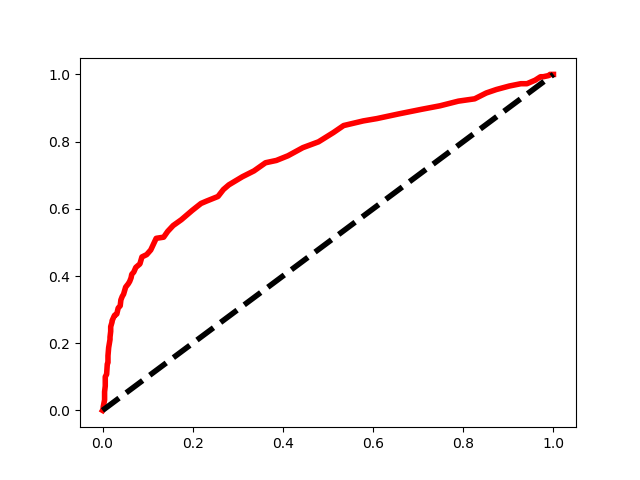

<IPython.core.display.Javascript object>


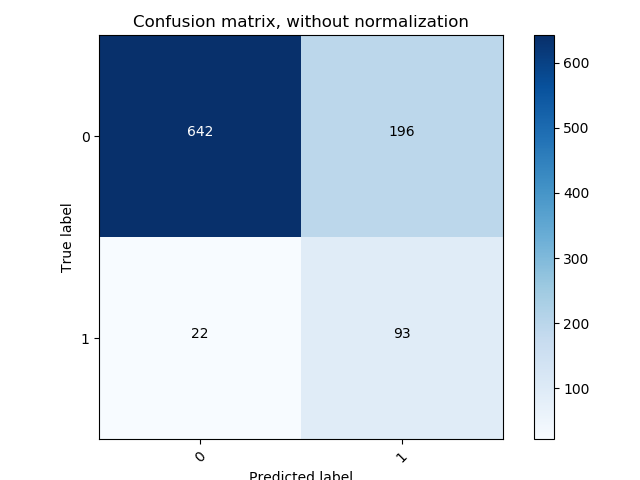

In [199]:
# The baseline predictions are the historical averages
baseline_preds = X_test[:, feature_list.index('sc17_cat')]
baseline_preds[:] = 0
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

# rf = RandomForestClassifier(n_estimators=1000, random_state=42)
# rf.fit(features_resamp, labels_resamp);

# Use the forest's predict method on the test data
y_preds = clf.predict(X_test)
# predictions = rf.predict(features_val)
# Calculate the absolute errors
errors = abs(y_preds - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))


cnf_matrix = confusion_matrix(y_preds, y_test, labels=range(2))

plt.figure()
plt.interactive(False)
plot_confusion_matrix(cnf_matrix, classes=range(2),
                      title='Confusion matrix, without normalization')
plt.show()

In [205]:
# Get numerical feature importances
classifier = clf.best_estimator_.steps[-1]
forest = classifier[1]
importances = list(forest.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
# Print out the feature and importances
print('Feature importance:')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
pass

Feature importance:
Variable: sec_commits17        Importance: 0.18
Variable: l_sc17               Importance: 0.18
Variable: lsc17                Importance: 0.17
Variable: sc17_cat             Importance: 0.11
Variable: main_commits         Importance: 0.04
Variable: l_mc                 Importance: 0.03
Variable: readme_len           Importance: 0.01
Variable: readme_size          Importance: 0.01
Variable: url_count            Importance: 0.01
Variable: code_files           Importance: 0.01
Variable: code_files_examined  Importance: 0.01
Variable: code_loc             Importance: 0.01
Variable: code_lloc            Importance: 0.01
Variable: code_sloc            Importance: 0.01
Variable: code_comments        Importance: 0.01
Variable: code_multi           Importance: 0.01
Variable: code_blank           Importance: 0.01
Variable: code_single_comments Importance: 0.01
Variable: code_classes_complexity Importance: 0.01
Variable: total_complexity     Importance: 0.01
Variable: code_fi

In [232]:
X_train, X_test = (features_train, features_test)
y_train, y_test = (labels_train, labels_test)

scaler = preprocessing.StandardScaler().fit(X_train)
X_test_scaled = scaler.transform(X_test)
pipeline = make_pipeline(preprocessing.StandardScaler(), linear_model.LinearRegression)

In [233]:
predictions = clf.predict_proba(X_test[0:1,:])
predictions

array([[0.16692132, 0.83307868]])

<IPython.core.display.Javascript object>


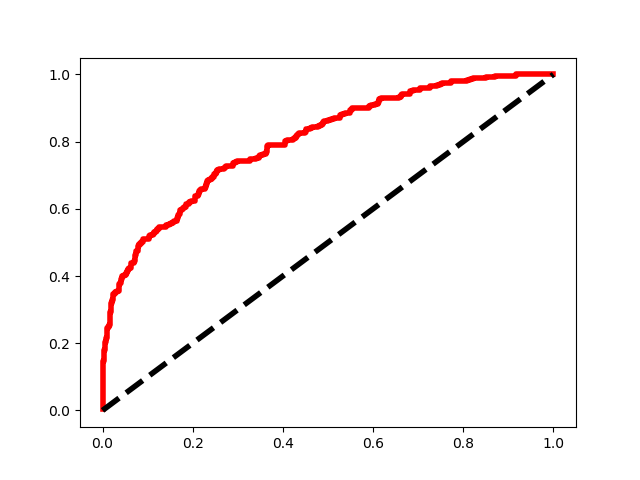

In [234]:
mean_fpr = np.linspace(0, 1, 100)
probas_ = clf.predict_proba(X_test)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
tprs = interp(mean_fpr, fpr, tpr)
tprs[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=4, label='ROC (AUC = %0.2f)' % roc_auc, color='red')
plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='black',
         label='Luck')

main_table = remove_unnamed_cols(pd.read_csv('bigs_main_table.csv'))

In [207]:
roc_auc

0.7720536123733689

In [184]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train, feature_names=main_table.columns)

In [185]:
X_test.shape

(953, 61)

In [186]:
clf.predict_proba(X_test[0:3,:])

array([[0.81, 0.19],
       [0.81, 0.19],
       [0.79, 0.21]])

In [190]:
i = 83
exp = explainer.explain_instance(X_test[0,:], clf.predict_proba, num_features=10)
exp_list = exp.as_list()
exp.as_list()

[('url <= 0.00', -0.017782017398986744),
 ('readme_size <= 0.00', -0.016126182204855392),
 ('sc_diff > 0.32', 0.009746808711320077),
 ('name <= 11.00', -0.00898909712910119),
 ('code_files_examined > 121.00', 0.008162824748649121),
 ('code_lloc > 22.70', 0.008084720890745925),
 ('code_multi > 23.50', 0.008020668161480981),
 ('sec_commits18 <= 1.00', 0.0),
 ('code_halstead_time <= 0.00', 0.0),
 ('code_halstead_N2_avg <= 0.00', 0.0)]

In [194]:
for exp_text, coeff in exp.as_list():
    text_chunks = exp_text.split()
    feature = [chunk for chunk in text_chunks if chunk[0].isalpha][0]
    print(feature)


url <= 0.00 -0.017782017398986744
url
readme_size <= 0.00 -0.016126182204855392
readme_size
sc_diff > 0.32 0.009746808711320077
sc_diff
name <= 11.00 -0.00898909712910119
name
code_files_examined > 121.00 0.008162824748649121
code_files_examined
code_lloc > 22.70 0.008084720890745925
code_lloc
code_multi > 23.50 0.008020668161480981
code_multi
sec_commits18 <= 1.00 0.0
sec_commits18
code_halstead_time <= 0.00 0.0
code_halstead_time
code_halstead_N2_avg <= 0.00 0.0
code_halstead_N2_avg


In [111]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names = feature_list,
                                                   kernel_width=3, verbose=False)

In [112]:
predict_fn = lambda x: clf.predict_proba(X_test)

In [235]:
exp = explainer.explain_instance(X_test[i], clf.predict_proba, num_features=10)
exp.show_in_notebook()

In [ ]:
main_table['secdiff'] = np.log(main_table.sec_commits18+1) - np.log(main_table.sec_commits17+1)

In [38]:
main_table.columns

Index(['project_id', 'name', 'readme_len', 'readme_size', 'readme_headers',
       'pipeline_status', 'url_count', 'img_count', 'code_files',
       'code_files_examined', 'code_loc', 'code_lloc', 'code_sloc',
       'code_comments', 'code_multi', 'code_blank', 'code_single_comments',
       'code_functions_complexity', 'code_classes_complexity',
       'total_complexity', 'code_halstead_h1', 'code_halstead_h2',
       'code_halstead_N1', 'code_halstead_N2', 'code_halstead_vocabulary',
       'code_halstead_length', 'code_halstead_calculated_length',
       'code_halstead_volume', 'code_halstead_difficulty',
       'code_halstead_effort', 'code_halstead_time', 'code_halstead_bugs',
       'code_pylint_score', 'url', 'main_commits', 'sec_commits17',
       'sec_commits18', 'cloned', 'sec_commits18_times4', 'sc17_cat',
       'sc18_cat', 'sc_diff', 'sc_diff_sign', 'code_files_avg',
       'code_files_examined_avg', 'code_loc_avg', 'code_lloc_avg',
       'code_sloc_avg', 'code_comments_a

In [87]:
main_table.sort_values(by='secdiff', ascending=False).head()

project_id          name  readme_len  readme_size  readme_headers  \
649     15939748      mritools           0            0               0   
1560    40980166  airbnb_clone        1983           55               8   
968     25978150  scikit-build        5820           67               6   
1674    43673841         olypy        1683           61               5   
1536    40239584        galaxy        2105           67               4   

      pipeline_status  url_count  img_count  code_files  code_files_examined  \
649                 0          0          0          19                   10   
1560                0          1          0          20                   10   
968                 0         31         13          47                   10   
1674                0          6          0          34                   10   
1536                0         16          6        1110                   10   

        ...     code_halstead_effort_avg  code_halstead_time_avg  \
649     ...                    89.771445                4.987302   
1560    ...                     1.007937                0.055996   
968     ...                     9.848602                0.547145   
1674    ...                    83.138233                4.618791   
1536    ...                    24.840049                1.380003   

      code_halstead_bugs_avg  code_pylint_score_avg    l_sc17      l_mc  \
649                 0.002807                    0.0  0.009950  0.698135   
1560                0.000318                    0.0  0.009950  0.009950   
968                 0.000953                    0.0  0.009950  3.970481   
1674                0.002558                    0.0  0.698135  5.480681   
1536                0.001232                    0.0  0.009950  3.178470   

      diff_cat     lsc17     lsc18   secdiff  
649          2  0.009950  6.612054  4.537961  
1560         2  0.009950  6.369918  4.297285  
968          2  0.009950  5.634825  3.569533  
1674         2  0.698135  6.040279  3.564827  
1536         2  0.009950  5.605839  3.540959  

[5 rows x 73 columns]

In [102]:
lm = linear_model.LinearRegression()
X = main_table #[['main_commits', 'sec_commits17', 'readme_len']]

X = X.assign(log_sec_commits17 = np.log(X['sec_commits17'] + 1))
# X = X.assign(log_readme_len = np.log(X['readme_len'] + 1))
X = X.assign(log_main_commits = np.log(X['main_commits'] + 1))
X = X.assign(rd2 = np.power(X['readme_len'], 2))
X = X.assign(csize1 = (X['sec_commits17'] < 10) * 1)
X = X.assign(csize10 = ((X['sec_commits17'] >= 10) & (X['sec_commits17'] < 100)) * 1)
X = X.assign(csize100 = ((X['sec_commits17'] >= 100) & (X['sec_commits17'] < 1000)) * 1)
X = X.assign(csize1000 = ((X['sec_commits17'] >= 1000) & (X['sec_commits17'] < 10000)) * 1)

X = X.assign(rd_size1 = X['csize1'] * X['readme_len'])
X = X.assign(rd_size10 = X['csize10'] * X['readme_len'])
X = X.assign(rd_size100 = X['csize100'] * X['readme_len'])
X = X.assign(rd_size1000 = X['csize1000'] * X['readme_len'])

X = X.assign(rd2_size1 = X['csize1'] * X['rd2'])
X = X.assign(rd2_size10 = X['csize10'] * X['rd2'])
X = X.assign(rd2_size100 = X['csize100'] * X['rd2'])
X = X.assign(rd2_size1000 = X['csize1000'] * X['rd2'])
X = X.drop(['name','url','cloned'], axis=1)
X.columns

Index(['project_id', 'readme_len', 'readme_size', 'readme_headers',
       'pipeline_status', 'url_count', 'img_count', 'code_files',
       'code_files_examined', 'code_loc', 'code_lloc', 'code_sloc',
       'code_comments', 'code_multi', 'code_blank', 'code_single_comments',
       'code_functions_complexity', 'code_classes_complexity',
       'total_complexity', 'code_halstead_h1', 'code_halstead_h2',
       'code_halstead_N1', 'code_halstead_N2', 'code_halstead_vocabulary',
       'code_halstead_length', 'code_halstead_calculated_length',
       'code_halstead_volume', 'code_halstead_difficulty',
       'code_halstead_effort', 'code_halstead_time', 'code_halstead_bugs',
       'code_pylint_score', 'main_commits', 'sec_commits17', 'sec_commits18',
       'sec_commits18_times4', 'sc17_cat', 'sc18_cat', 'sc_diff',
       'sc_diff_sign', 'code_files_avg', 'code_files_examined_avg',
       'code_loc_avg', 'code_lloc_avg', 'code_sloc_avg', 'code_comments_avg',
       'code_multi_avg', 'c

In [103]:
X.sort_values(by='sec_commits17').head()

project_id  readme_len  readme_size  readme_headers  pipeline_status  \
2289    53624886           0            0               0                0   
933     22694091        1270           19               0                0   
1736    42941786        3509           81               3                0   
4119    36684455        1829           61               5                0   
4268    33378673        1188           25               2                0   

      url_count  img_count  code_files  code_files_examined    code_loc  \
2289          0          0           5                    2   40.000000   
933           0          0           9                    7  367.428571   
1736          4          0          92                   10  198.600000   
4119          4          0           1                    1   35.000000   
4268          4          0           1                    1   38.000000   

          ...       csize100  csize1000  rd_size1  rd_size10  rd_size100  \
2289      ...              0          0         0          0           0   
933       ...              0          0      1270          0           0   
1736      ...              0          0      3509          0           0   
4119      ...              0          0      1829          0           0   
4268      ...              0          0      1188          0           0   

      rd_size1000  rd2_size1  rd2_size10  rd2_size100  rd2_size1000  
2289            0          0           0            0             0  
933             0    1612900           0            0             0  
1736            0   12313081           0            0             0  
4119            0    3345241           0            0             0  
4268            0    1411344           0            0             0  

[5 rows x 84 columns]

In [104]:
y = main_table['sec_commits18']
#y = y.sample(frac=1)
y.head()

0    6643
1    1649
2    1619
3    1386
4    1168
Name: sec_commits18, dtype: int64

In [105]:
ysize0 = (y == 0) * 1
ysize1 = (y == 1) * 1
ysize0.head()
ylog = np.log(y + 1)

In [106]:
ycat = y
# ycat = y.loc[(3 <= y)]

In [107]:
poissonm = sm.GLM(ylog, sm.add_constant(X), family=sm.families.Poisson()).fit()
poissonm.summary()

/Users/lasindi/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/lasindi/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:131: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/Users/lasindi/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:131: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/Users/lasindi/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1129: RuntimeWarning: invalid value encountered in multiply
  - self._offset_exposure)
/Users/lasindi/anaconda3/envs/insight/lib/python3.6/site-packages/statsmodels/regression/_tools.py:49: RuntimeWarning: invalid value encountered in 

ValueError: On entry to DGELSD parameter number 4 had an illegal value

In [108]:
model = sm.OLS(ylog, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sec_commits18   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.145e+04
Date:                Mon, 25 Jun 2018   Prob (F-statistic):               0.00
Time:                        22:38:27   Log-Likelihood:                 7326.2
No. Observations:                4762   AIC:                        -1.452e+04
Df Residuals:                    4694   BIC:                        -1.408e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
project_id                           2.506e-11   3.97e-11      0.631      0.528   -5.27e-11    1.03e-10
readme_len                          -4.462e-06   6.68e-07     -6.677      0.000   -5.77e-06   -3.15e-06
readme_size                         -4.191e-06   1.15e-05     -0.364      0.716   -2.68e-05    1.84e-05
readme_headers                       2.403e-05   9.06e-05      0.265      0.791      -0.000       0.000
pipeline_status                         0.0408      0.023      1.738      0.082      -0.005       0.087
url_count                           -1.155e-05   4.83e-05     -0.239      0.811      -0.000    8.32e-05
img_count                              -0.0001      0.000     -0.273      0.785      -0.001       0.001
code_files                           4.502e-06   3.43e-06      1.314      0.189   -2.21e-06    1.12e-05
code_files_examined                    -0.0003      0.000     -0.905      0.366      -0.001       0.000
code_loc                               -0.0002      0.000     -0.559      0.576      -0.001       0.001
code_lloc                           -3.696e-05   2.44e-05     -1.514      0.130   -8.48e-05    1.09e-05
code_sloc                               0.0003      0.000      0.590      0.555      -0.001       0.001
code_comments                       -6.005e-05      0.000     -0.484      0.629      -0.000       0.000
code_multi                             -0.0002      0.000     -0.516      0.606      -0.001       0.001
code_blank                           4.725e-05      6e-05      0.787      0.431   -7.05e-05       0.000
code_single_comments                   -0.0002      0.000     -0.384      0.701      -0.001       0.001
code_functions_complexity           -6.297e-05      0.000     -0.590      0.555      -0.000       0.000
code_classes_complexity             -4.558e-05      0.000     -0.453      0.650      -0.000       0.000
total_complexity                        0.0002      0.000      0.877      0.381      -0.000       0.001
code_halstead_h1                       -0.0018      0.002     -0.938      0.348      -0.005       0.002
code_halstead_h2                        0.0015      0.001      1.099      0.272      -0.001       0.004
code_halstead_N1                       -0.0004      0.000     -1.264      0.206      -0.001       0.000
code_halstead_N2                    -8.168e-05      0.000     -0.230      0.818      -0.001       0.001
code_halstead_vocabulary               -0.0003      0.001     -0.491      0.624      -0.001       0.001
code_halstead_length                   -0.0005      0.000     -1.801      0.072      -0.001    4.32e-05
code_halstead_calculated_length        -0.0001   8.31e-05     -1.684      0.092      -0.000     2.3e-05
code_halstead_volume                 7.956e-05   4.05e-05      1.96

In [57]:
print(poissonm.aic, model.aic)

27804.530840082483 13096.238126330512


In [58]:
X.shape

(4762, 18)

In [59]:
y = y.rename('sec_commits18')

In [60]:
yX = pd.concat([X,y], axis=1)

In [61]:
yX.sort_values(by=['sec_commits17']).head()

main_commits  sec_commits17  readme_len  log_sec_commits17  \
2289             1              1           0           0.693147   
933              1              1        1270           0.693147   
1736            12              1        3509           0.693147   
4119            32              1        1829           0.693147   
4268             3              1        1188           0.693147   

      log_main_commits       rd2  csize1  csize10  csize100  csize1000  \
2289          0.693147         0       1        0         0          0   
933           0.693147   1612900       1        0         0          0   
1736          2.564949  12313081       1        0         0          0   
4119          3.496508   3345241       1        0         0          0   
4268          1.386294   1411344       1        0         0          0   

      rd_size1  rd_size10  rd_size100  rd_size1000  rd2_size1  rd2_size10  \
2289         0          0           0            0          0           0   
933       1270          0           0            0    1612900           0   
1736      3509          0           0            0   12313081           0   
4119      1829          0           0            0    3345241           0   
4268      1188          0           0            0    1411344           0   

      rd2_size100  rd2_size1000  sec_commits18  
2289            0             0              0  
933             0             0              3  
1736            0             0              0  
4119            0             0              0  
4268            0             0              0

<IPython.core.display.Javascript object>


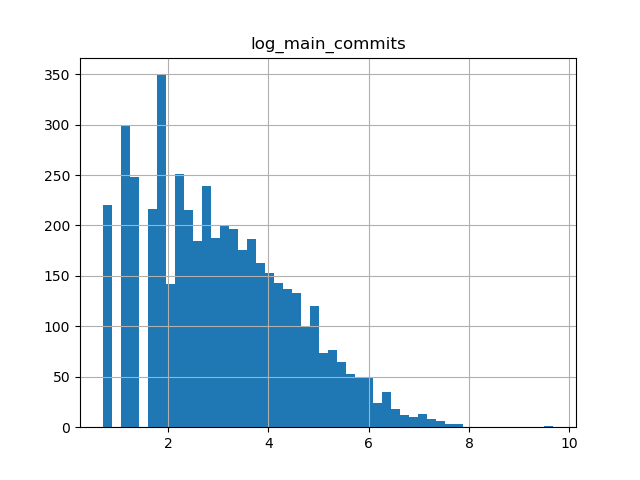

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11200ebe0>]],
      dtype=object)

In [67]:
yX.hist(column='log_main_commits', bins=50)

In [ ]:
# plot = yX.hist(column='diff_sc', bins=100)
yX = yX.assign(diffsc = (yX['code_'] - yX['sec_commits17']))
plt.hist(yX['diffsc'].values, bins=30, range=(-50, 50))
plt.show()

<IPython.core.display.Javascript object>


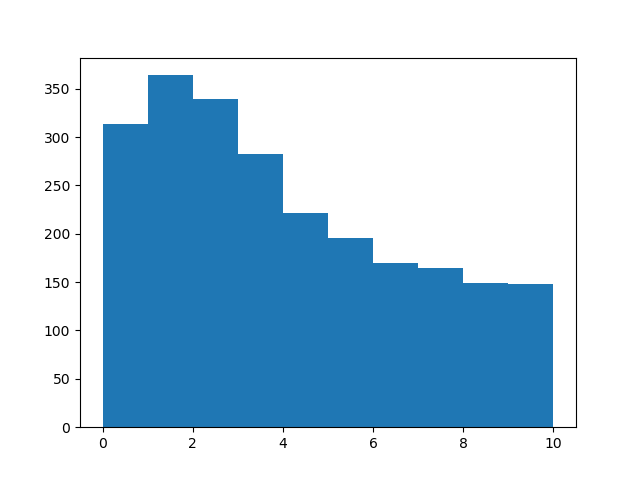

In [41]:
# plot = yX.hist(column='diff_sc', bins=100)
# yX = yX.assign(diffsc = (yX['code_comments']))
plt.hist(main_table['code_comments'].values, bins=10, range=(0, 10))
plt.show()

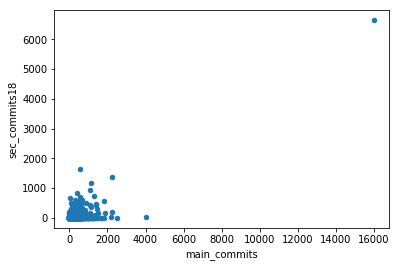

In [120]:
yX.sort_values(by='readme_len').plot.scatter(x='main_commits', y='sec_commits18')

(0, 500)

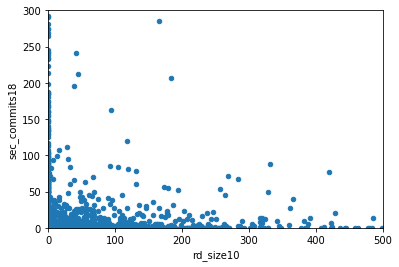

In [133]:
ax = yX.sort_values(by='readme_len').plot.scatter(x='rd_size10', y='sec_commits18')
ax.set_ylim((0,300))
ax.set_xlim((0,500))

In [21]:
yX = yX.assign(diff_sec_commits = X['log_sec_commits17'] - y)

In [1]:
yX.plot.scatter(x='readme_len', y='log_sec_commits18')

NameError: name 'yX' is not defined